# Stochastic RSI strategy
## Second derivative of RSI...
- Buy when it is at a discounted px (<= 2 sd) and oversold
- Sell when it is at a premium px (>= 2 sd) and overbought

In [40]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
import XLML

In [41]:
goog = yf.Ticker("GOOG")
df = goog.history(period="5y")
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-06-04   56.116501   57.094501   56.100250   56.964500  37792000  \
1     2018-06-05   57.049500   57.286900   56.659500   56.983002  33560000   
2     2018-06-06   57.108501   57.150002   56.287151   56.844002  33964000   
3     2018-06-07   56.566002   56.791000   55.826000   56.193001  30400000   
4     2018-06-08   55.909000   56.333500   55.607498   56.043499  25816000   
...          ...         ...         ...         ...         ...       ...   
1253  2023-05-25  125.209999  125.980003  122.900002  124.349998  33812700   
1254  2023-05-26  124.065002  126.000000  123.290001  125.430000  25154700   
1255  2023-05-30  126.290001  126.379997  122.889999  124.639999  27230700   
1256  2023-05-31  123.699997  124.900002  123.099998  123.370003  41548800   
1257  2023-06-01  123.500000  125.040001  123.300003  124.370003  25009300   

      Dividends  Stock Splits  
0           0.0           0.0  

In [42]:
# Calculate StochRSI of the stock using TA-Lib
df['StochRSI_fastK'],df['StochRSI_fastD'] = talib.STOCHRSI(df['Close'], timeperiod=14, fastk_period=3, fastd_period=3, fastd_matype=0)

# Calculate bollinger bands of the stock using TA-Lib
df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

In [47]:
def strategy(data):
    buy_threshold = 25
    sell_threshold = 75
    pos = 0
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        stochrsi_buy = (data['StochRSI_fastK'][i] < buy_threshold) and (data['StochRSI_fastD'][i] < buy_threshold) and (data['StochRSI_fastK'][i] < data['StochRSI_fastD'][i])
        stochrsi_sell = (data['StochRSI_fastK'][i] > sell_threshold) and (data['StochRSI_fastD'][i] > sell_threshold) and (data['StochRSI_fastK'][i] > data['StochRSI_fastD'][i])
        if (data['Close'][i] < data['Bollinger Low'][i]) and stochrsi_buy and pos == 0:
            buy_price.append(data['Close'][i])
            sell_price.append(np.nan)
            pos = 1
        elif (data['Close'][i] > data['Bollinger High'][i]) and stochrsi_sell and pos == 1:
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
            pos = 0
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return (buy_price, sell_price)
buy_price, sell_price = strategy(df)
df['Buy'] = buy_price
df['Sell'] = sell_price
print(df)

            Date        Open        High         Low       Close    Volume   
0     2018-06-04   56.116501   57.094501   56.100250   56.964500  37792000  \
1     2018-06-05   57.049500   57.286900   56.659500   56.983002  33560000   
2     2018-06-06   57.108501   57.150002   56.287151   56.844002  33964000   
3     2018-06-07   56.566002   56.791000   55.826000   56.193001  30400000   
4     2018-06-08   55.909000   56.333500   55.607498   56.043499  25816000   
...          ...         ...         ...         ...         ...       ...   
1253  2023-05-25  125.209999  125.980003  122.900002  124.349998  33812700   
1254  2023-05-26  124.065002  126.000000  123.290001  125.430000  25154700   
1255  2023-05-30  126.290001  126.379997  122.889999  124.639999  27230700   
1256  2023-05-31  123.699997  124.900002  123.099998  123.370003  41548800   
1257  2023-06-01  123.500000  125.040001  123.300003  124.370003  25009300   

      Dividends  Stock Splits  StochRSI_fastK  StochRSI_fastD  

In [50]:
#PnL results
buy_signals = df['Buy'].dropna().reset_index(drop=True)
sell_signals = df['Sell'].dropna().reset_index(drop=True)
pnl = sell_signals - buy_signals
accruacy = pnl[pnl>0].sum()/abs(pnl).sum()
print('Accruacy (pro-rata): ', accruacy)
print('Total PnL: ', pnl.sum())
print('PnL record in pair:\n', pnl)

Accruacy (pro-rata):  0.6915846845580177
Total PnL:  21.38448715209961
PnL record in pair:
 0     7.662998
1     4.767998
2    11.182495
3     9.253494
4    -2.528503
5   -14.683998
6     5.730003
dtype: float64


In [51]:
buy_days = df['Date'][df['Buy'].notna()].reset_index(drop=True)
sell_days = df['Date'][df['Sell'].notna()].reset_index(drop=True)
print('Buy days:\n', buy_days)
print('Sell days:\n', sell_days)
trade_duration = sell_days - buy_days
# transfrom trade_duration to numbers
trade_duration = trade_duration.apply(lambda x: x.days)
print('Trade duration: ', trade_duration)
print('Average trade duration: ', trade_duration.mean())

Buy days:
 0    2018-12-21
1    2019-06-03
2    2020-02-27
3    2021-09-20
4    2021-11-26
5    2022-04-22
6    2022-11-02
Name: Date, dtype: object
Sell days:
 0    2019-02-04
1    2019-07-05
2    2020-07-10
3    2021-10-29
4    2022-03-22
5    2022-10-25
6    2023-01-13
Name: Date, dtype: object
Trade duration:  0     45
1     32
2    134
3     39
4    116
5    186
6     72
Name: Date, dtype: int64
Average trade duration:  89.14285714285714


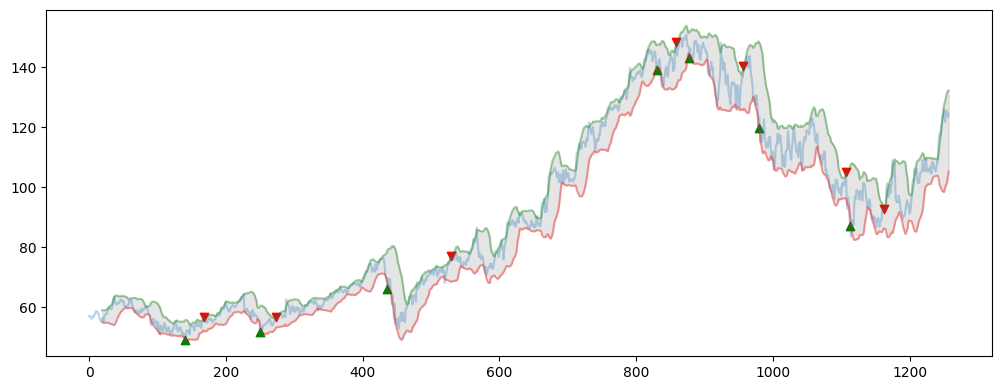

In [52]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['Close'], label='Close', alpha = 0.3)
plt.plot(df['Bollinger High'], label='Bollinger High', color='green', alpha=0.35)
plt.plot(df['Bollinger Low'], label='Bollinger Low', color='red', alpha=0.35)
plt.fill_between(df.index, df['Bollinger High'], df['Bollinger Low'], color='grey', alpha=0.2)
plt.scatter(df.index, df['Buy'], label='Buy', marker='^', color='green')
plt.scatter(df.index, df['Sell'], label='Sell', marker='v', color='red')
plt.show()

In [55]:
from concurrent.futures import ThreadPoolExecutor
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df_temp = pd.read_html(url)[0]
stock_list = df_temp['Symbol'].to_list()
stocks = yf.Tickers(stock_list).history(period="5y")

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BAC: No data found for this date range, symbol may be delisted


In [56]:
df2 = stocks.reset_index()['Close']
df2 = df2.dropna(axis=1, how='all')

In [57]:
def process_ticker(ticker):
    df = yf.Ticker(ticker).history(period="5y").reset_index()
    df['StochRSI_fastK'],df['StochRSI_fastD'] = talib.STOCHRSI(df['Close'], timeperiod=14, fastk_period=3, fastd_period=3, fastd_matype=0)
    df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    buy_price, sell_price = strategy(df)
    df['Buy'] = buy_price
    df['Sell'] = sell_price
    buy_signals = df['Buy'].dropna().reset_index(drop=True)
    sell_signals = df['Sell'].dropna().reset_index(drop=True)
    pnl = sell_signals - buy_signals
    accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()
    return ticker, accuracy, pnl.sum()

tickers = df2.columns

with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_ticker, tickers))

results_dict = {}
for ticker, accuracy, pnl in results:
    results_dict[ticker] = {'accuracy': accuracy, 'pnl': pnl}

/var/folders/gb/y91d_0014dlgwfxhcglf4drc0000gn/T/ipykernel_33659/3227068747.py:11: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()


In [58]:
backtests = pd.DataFrame(results_dict).from_dict(results_dict, orient='index')
print(backtests)

      accuracy         pnl
A     0.645048   22.650818
AAL   0.436027   -3.327565
AAP   0.584744   15.733879
AAPL  0.809725   53.437294
ABBV  0.817250   27.483009
...        ...         ...
YUM   0.727632   40.495560
ZBH   0.440836  -12.016899
ZBRA  0.659467  201.709991
ZION  0.297292  -21.432692
ZTS   0.332616  -25.793419

[500 rows x 2 columns]


In [59]:
gains = backtests['pnl'].where(backtests['pnl'] > 0, 0).sum()
loss = backtests['pnl'].where(backtests['pnl'] < 0, 0).sum()
win_ratio = gains / (gains + abs(loss))
print('Total PnL: ', backtests['pnl'].sum()
        , '\nTotal gains: ', gains, '\nTotal loss: ', loss)
print('Win ratio: ', win_ratio)

Total PnL:  26182.439504146576 
Total gains:  28591.522765159607 
Total loss:  -2409.083261013031
Win ratio:  0.9222891559287862


<Axes: >

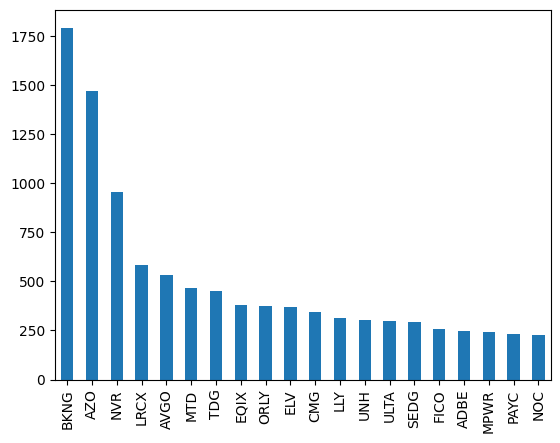

In [60]:
backtests['pnl'].sort_values(ascending=False).head(20).plot(kind='bar')